# This notebook processes EV charging data to separate session summaries from time interval data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set display options for better data viewing
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

## 1. Data Loading and Initial Exploration

def load_charging_data(file_path):
    """
    Load charging session data from CSV file
    """
    try:
        # Read the data
        df = pd.read_csv(file_path, sep='\t')  # Tab-separated based on the sample
        print(f"Data loaded successfully!")
        print(f"Shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

In [13]:
## 2. Data Cleaning and Organization Functions

def identify_session_structure(df):
    """
    Identify which rows are session summaries vs time interval data
    """
    # Session summary rows have complete information in summary fields
    # Time interval rows have power data but missing summary fields
    
    summary_mask = (
        df['Total Duration (hh:mm:ss)'].notna() & 
        df['Energy (kWh)'].notna() & 
        df['Station Name'].notna()
    )
    
    interval_mask = (
        df['Power Start Time'].notna() & 
        df['Power End Time'].notna() & 
        df['Peak Power (AC kW)'].notna() &
        df['Total Duration (hh:mm:ss)'].isna()
    )
    
    return summary_mask, interval_mask

def extract_session_summaries(df):
    """
    Extract session summary data
    """
    summary_mask, _ = identify_session_structure(df)
    
    summary_df = df[summary_mask].copy()
    
    # Clean and convert data types
    if not summary_df.empty:
        # Convert datetime columns
        datetime_cols = ['Plug Connect Time', 'Plug Disconnect Time', 'Start Time', 'End Time']
        for col in datetime_cols:
            if col in summary_df.columns:
                summary_df[col] = pd.to_datetime(summary_df[col], errors='coerce')
        
        # Convert numeric columns
        numeric_cols = ['Energy (kWh)', 'GHG Savings (kg)', 'Gasoline Savings', 'Fee', 'Latitude', 'Longitude']
        for col in numeric_cols:
            if col in summary_df.columns:
                summary_df[col] = pd.to_numeric(summary_df[col], errors='coerce')
        
        # Parse duration columns
        if 'Total Duration (hh:mm:ss)' in summary_df.columns:
            summary_df['Total Duration (minutes)'] = summary_df['Total Duration (hh:mm:ss)'].apply(parse_duration)
        if 'Charging Time (hh:mm:ss)' in summary_df.columns:
            summary_df['Charging Time (minutes)'] = summary_df['Charging Time (hh:mm:ss)'].apply(parse_duration)
    
    return summary_df

def extract_time_intervals(df, meter_columns):
    """
    Extract time interval data
    """
    _, interval_mask = identify_session_structure(df)
    
    interval_df = df[interval_mask].copy()
    
    if not interval_df.empty:
        # Convert datetime columns
        datetime_cols = ['Power Start Time', 'Power End Time']
        for col in datetime_cols:
            if col in interval_df.columns:
                interval_df[col] = pd.to_datetime(interval_df[col], errors='coerce')
        
        # Convert numeric columns
        numeric_cols = ['Peak Power (AC kW)', 'Rolling Avg. Power (AC kW)', 'Energy Consumed (AC kWh)']
        for col in numeric_cols:
            if col in interval_df.columns:
                interval_df[col] = pd.to_numeric(interval_df[col], errors='coerce')
        
        # # Calculate interval duration
        # if all(col in interval_df.columns for col in ['Power Start Time', 'Power End Time']):
        #     interval_df['Interval Duration (minutes)'] = (
        #         interval_df['Power End Time'] - interval_df['Power Start Time']
        #     ).dt.total_seconds() / 60
    
    return interval_df[meter_columns]

def parse_duration(duration_str):
    """
    Parse duration string in HH:MM:SS format to minutes
    """
    if pd.isna(duration_str):
        return np.nan
    
    try:
        parts = str(duration_str).split(':')
        if len(parts) == 3:
            hours, minutes, seconds = map(int, parts)
            return hours * 60 + minutes + seconds / 60
        return np.nan
    except:
        return np.nan

def organize_sessions_by_event_id(df):
    """
    Organize data by Plug In Event ID
    """
    # Get unique event IDs
    event_ids = df['Plug In Event Id'].unique()
    
    sessions_data = {}
    
    for event_id in event_ids:
        if pd.notna(event_id):
            # Filter data for this event
            event_data = df[df['Plug In Event Id'] == event_id].copy()
            
            # Separate summary and interval data
            summary_mask, interval_mask = identify_session_structure(event_data)
            
            session_summary = event_data[summary_mask]
            session_intervals = event_data[interval_mask]
            
            sessions_data[event_id] = {
                'summary': session_summary,
                'intervals': session_intervals,
                'total_records': len(event_data)
            }
    
    return sessions_data

## 1. Data Cleaning from raw charging session and meter data

In [21]:
# Load sample data for demonstration
df_raw = load_charging_data('data/chapter5/Session-Details-Meter-with-Summary-2018.txt')

# Extract meter columns
meter_columns = ['EVSE ID', 'User Id', 'Plug In Event Id',
                 'Power Start Time', 'Power End Time',
                 'Peak Power (AC kW)', 'Rolling Avg. Power (AC kW)',
                 'Energy Consumed (AC kWh)', 'Port']

Data loaded successfully!
Shape: (2488756, 44)
Columns: ['EVSE ID', 'User Id', 'Plug In Event Id', 'Firmware Ver.', 'Plug Connect Time', 'Plug Connect Time Zone', 'Plug Disconnect Time', 'Plug Disconnect Time Zone', 'Power Start Time', 'Power Start Time Zone', 'Power End Time', 'Power End Time Zone', 'Peak Power (AC kW)', 'Rolling Avg. Power (AC kW)', 'Energy Consumed (AC kWh)', 'Port', 'Station Name', 'MAC Address', 'Org Name', 'Start Time', 'Start Time Zone', 'End Time', 'End Time Zone', 'Total Duration (hh:mm:ss)', 'Charging Time (hh:mm:ss)', 'Energy (kWh)', 'GHG Savings (kg)', 'Gasoline Savings', 'Port Type', 'Address 1', 'Address 2', 'City', 'State/Province', 'Postal Code', 'Country', 'Latitude', 'Longitude', 'Currency', 'Fee', 'Ended By', 'Driver', 'Driver Name', 'Driver Account No.', 'Driver Postal Code']


## 3. Apply Data Cleaning

In [22]:
print("\n" + "="*60)
print("CLEANING AND ORGANIZING DATA")
print("="*60)

# Extract session summaries
print("\n1. Extracting session summaries...")
session_summaries = extract_session_summaries(df_raw)
print(f"Found {len(session_summaries)} session summaries")

# Extract time intervals
print("\n2. Extracting time interval data...")
time_intervals = extract_time_intervals(df_raw, meter_columns)
print(f"Found {len(time_intervals)} time interval records")

# Organize by event ID
print("\n3. Organizing sessions by Event ID...")
sessions_by_event = organize_sessions_by_event_id(df_raw)
print(f"Found {len(sessions_by_event)} unique charging sessions")


CLEANING AND ORGANIZING DATA

1. Extracting session summaries...
Found 53549 session summaries

2. Extracting time interval data...
Found 2385999 time interval records

3. Organizing sessions by Event ID...
Found 53547 unique charging sessions


In [44]:
# Display the shape of the selected sessions with metrics
print("\n5. Displaying session summaries with metrics...")
print(f"Session Summaries Shape: {session_summaries.shape}")
print(f"Time Intervals Shape: {time_intervals.shape}")
# Display the first few rows of the session summaries
print("\nSession Summaries Preview:")
print(session_summaries.head())
# Display the first few rows of the time intervals
print("\nTime Intervals Preview:")
print(time_intervals.head())
# Display the first few rows of the organized sessions by event ID
print("\nOrganized Sessions by Event ID Preview:")
selected_plugin_event_id = [14240497, 14239885]
for i, (event_id, data) in enumerate(sessions_by_event.items()):
    if event_id in selected_plugin_event_id:
        print(f"\nEvent ID: {event_id}")
        print(f"Summary shape: {data['summary'].shape}")
        print(f"Intervals shape: {data['intervals'].shape}")
        print(f"Total records: {data['total_records']}")



5. Displaying session summaries with metrics...
Session Summaries Shape: (53549, 46)
Time Intervals Shape: (2385999, 9)

Session Summaries Preview:
   EVSE ID User Id  Plug In Event Id                       Firmware Ver.  \
0   228184  33831V         183610581  4.3.4.13 Build 83512 CT4knandflash   
1    34233  146547         183596821      4.0.7.32 Build 83488 dataflash   
2   122387   6279V         183583741  4.3.4.13 Build 83512 CT4knandflash   
3   123517   7399V         183574141  4.3.4.13 Build 83512 CT4knandflash   
4   122391   7401V         183570791  4.3.4.13 Build 83512 CT4knandflash   

    Plug Connect Time Plug Connect Time Zone Plug Disconnect Time  \
0 2018-02-09 12:48:44                    PST                  NaT   
1 2018-02-09 12:31:10                    PST                  NaT   
2 2018-02-09 12:12:37                    PST                  NaT   
3 2018-02-09 12:01:45                    PST                  NaT   
4 2018-02-09 11:59:27                    PST     

## 2. Data Analysis and Visualization

In [7]:
def analyze_session_data(sessions_dict):
    """
    Analyze the organized session data
    """
    print("\n" + "="*60)
    print("SESSION DATA ANALYSIS")
    print("="*60)
    
    for event_id, session_data in sessions_dict.items():
        print(f"\n--- Event ID: {event_id} ---")
        
        # Summary info
        if not session_data['summary'].empty:
            summary = session_data['summary'].iloc[0]
            print(f"Station: {summary.get('Station Name', 'N/A')}")
            print(f"User ID: {summary.get('User Id', 'N/A')}")
            print(f"Total Energy: {summary.get('Energy (kWh)', 'N/A')} kWh")
            print(f"Total Duration: {summary.get('Total Duration (hh:mm:ss)', 'N/A')}")
            print(f"Charging Time: {summary.get('Charging Time (hh:mm:ss)', 'N/A')}")
        
        # Interval info
        intervals = session_data['intervals']
        if not intervals.empty:
            print(f"Number of intervals: {len(intervals)}")
            print(f"Peak power: {intervals['Peak Power (AC kW)'].max():.2f} kW")
            print(f"Average power: {intervals['Rolling Avg. Power (AC kW)'].mean():.2f} kW")
            print(f"Total interval energy: {intervals['Energy Consumed (AC kWh)'].sum():.2f} kWh")

def plot_charging_profiles(sessions_dict):
    """
    Plot charging profiles for each session
    """
    fig, axes = plt.subplots(len(sessions_dict), 2, figsize=(15, 6*len(sessions_dict)))
    if len(sessions_dict) == 1:
        axes = axes.reshape(1, -1)
    
    for i, (event_id, session_data) in enumerate(sessions_dict.items()):
        intervals = session_data['intervals']
        
        if not intervals.empty and 'Power Start Time' in intervals.columns:
            # Plot 1: Power over time
            ax1 = axes[i, 0]
            ax1.plot(intervals['Power Start Time'], intervals['Peak Power (AC kW)'], 'b-', linewidth=2, label='Peak Power')
            ax1.plot(intervals['Power Start Time'], intervals['Rolling Avg. Power (AC kW)'], 'r--', linewidth=2, label='Avg Power')
            ax1.set_title(f'Event {event_id}: Power Profile')
            ax1.set_xlabel('Time')
            ax1.set_ylabel('Power (kW)')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            ax1.tick_params(axis='x', rotation=45)
            
            # Plot 2: Cumulative energy
            ax2 = axes[i, 1]
            cumulative_energy = intervals['Energy Consumed (AC kWh)'].cumsum()
            ax2.plot(intervals['Power Start Time'], cumulative_energy, 'g-', linewidth=2)
            ax2.set_title(f'Event {event_id}: Cumulative Energy')
            ax2.set_xlabel('Time')
            ax2.set_ylabel('Cumulative Energy (kWh)')
            ax2.grid(True, alpha=0.3)
            ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

def create_summary_statistics(session_summaries, time_intervals):
    """
    Create summary statistics
    """
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    
    if not session_summaries.empty:
        print("\nSession Summary Statistics:")
        print(f"Total Sessions: {len(session_summaries)}")
        print(f"Total Energy Delivered: {session_summaries['Energy (kWh)'].sum():.2f} kWh")
        print(f"Average Energy per Session: {session_summaries['Energy (kWh)'].mean():.2f} kWh")
        print(f"Average Duration: {session_summaries['Total Duration (minutes)'].mean():.0f} minutes")
        print(f"Average Charging Time: {session_summaries['Charging Time (minutes)'].mean():.0f} minutes")
    
    if not time_intervals.empty:
        print("\nTime Interval Statistics:")
        print(f"Total Intervals: {len(time_intervals)}")
        print(f"Average Peak Power: {time_intervals['Peak Power (AC kW)'].mean():.2f} kW")
        print(f"Maximum Peak Power: {time_intervals['Peak Power (AC kW)'].max():.2f} kW")
        print(f"Average Rolling Power: {time_intervals['Rolling Avg. Power (AC kW)'].mean():.2f} kW")


## 3. Execute EV Charging Session Analysis


5. Selecting sessions for analysis...

SESSION DATA ANALYSIS

--- Event ID: 14240497 ---
Station: ALAMEDA / EH 001
User ID: 158971.0
Total Energy: 18.38168 kWh
Total Duration: 05:37:18
Charging Time: 05:37:13
Number of intervals: 24
Peak power: 6.04 kW
Average power: 3.19 kW
Total interval energy: 18.38 kWh

SUMMARY STATISTICS

Session Summary Statistics:
Total Sessions: 53549
Total Energy Delivered: 462148.57 kWh
Average Energy per Session: 8.63 kWh
Average Duration: 666 minutes
Average Charging Time: 148 minutes

Time Interval Statistics:
Total Intervals: 2385999
Average Peak Power: 0.91 kW
Maximum Peak Power: 1082.34 kW
Average Rolling Power: 0.82 kW

CHARGING PROFILES


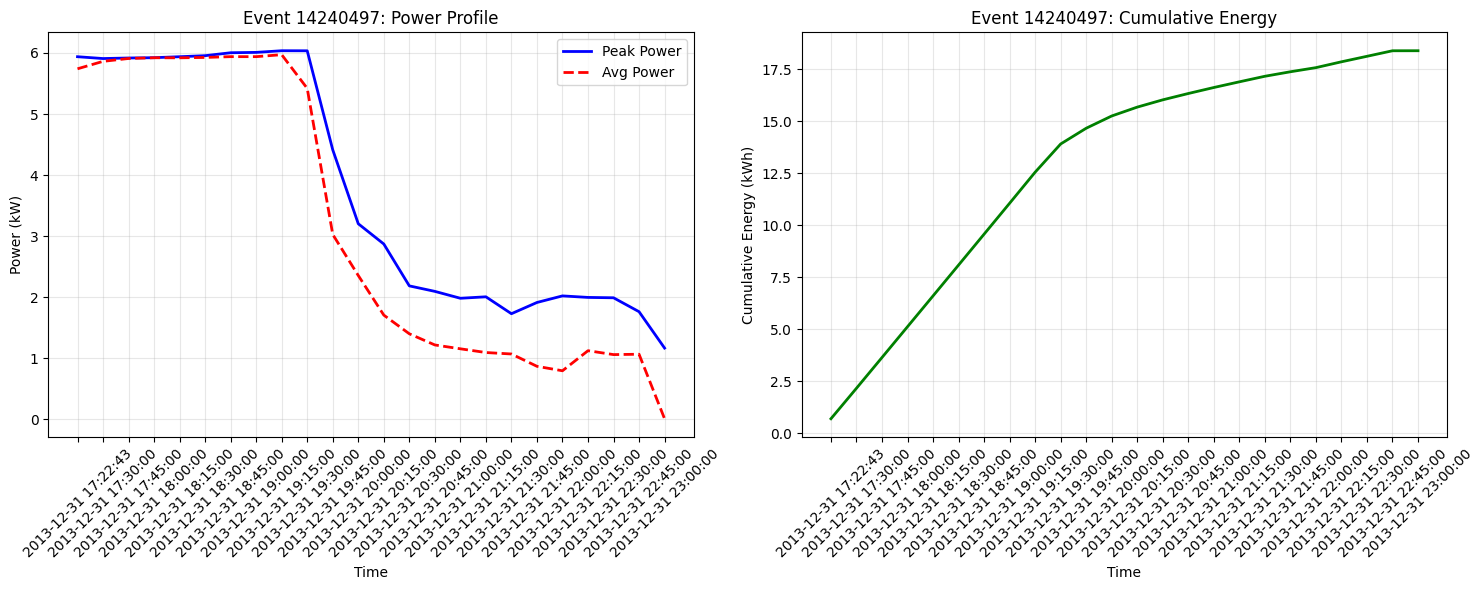

In [46]:
# Select the first 10 sessions  with non empty time intervals for analysis
selected_plugin_event_id = [14240497]
# Select sessions by event ID
print("\n5. Selecting sessions for analysis...")
selected_sessions = {k: v for i, (k, v) in enumerate(sessions_by_event.items()) if k in selected_plugin_event_id}

# Analyze session data
analyze_session_data(selected_sessions)

# Create summary statistics
create_summary_statistics(session_summaries, time_intervals)

# Plot charging profiles
print("\n" + "="*60)
print("CHARGING PROFILES")
print("="*60)
plot_charging_profiles(selected_sessions)

## 4. Export Cleaned Data

In [ ]:
# Save organized data to CSV files
print("\n4. Saving organized data to CSV files...")
session_summaries.to_csv('data/chapter5/session_summaries_2018.csv', index=False)
time_intervals.to_csv('data/chapter5/session_intervals_2018.csv', index=False)


EXPORTING CLEANED DATA
Session summaries exported to ./session_summaries.csv
Time intervals exported to ./time_intervals.csv
Individual session files exported for 2 events


## 5. Utility Functions for Session Analysis

In [ ]:
def get_session_by_event_id(event_id, sessions_dict):
    """
    Get specific session data by event ID
    """
    return sessions_dict.get(event_id, None)

In [47]:
# Select columns to simplify the output

select_session_columns = [
    'EVSE ID', 'User Id', 'Plug In Event Id',
    'Port', 'Station Name', 'User Id', 'Port Type',
    'Energy (kWh)', 'Total Duration (hh:mm:ss)', 
    'Charging Time (hh:mm:ss)', 'Plug Connect Time', 
    'Plug Disconnect Time', 'Start Time', 'End Time',
    'Address 1', 'City', 'Postal Code'
]

# New dataframe with selected columns
selected_sessions = session_summaries[select_session_columns].copy()
# Display the first few rows of the selected sessions
print("\n" + "="*60)
print("SELECTED SESSION COLUMNS")
print("="*60)
print(selected_sessions.head())
# Display the shape of the selected sessions
print(f"Shape of selected sessions: {selected_sessions.shape}")


SELECTED SESSION COLUMNS
   EVSE ID User Id  Plug In Event Id  Port                    Station Name  \
0   228184  33831V         183610581     2         ALAMEDA / AMADOR 4K 005   
1    34233  146547         183596821     2               ALAMEDA / JJC 002   
2   122387   6279V         183583741     2  ALCO STATIONS / ALCOBASE4000-3   
3   123517   7399V         183574141     1       ALAMEDA / TURNER PWA - 01   
4   122391   7401V         183570791     2     ADFADS   A / ELMHURST - 002   

  User Id Port Type  Energy (kWh) Total Duration (hh:mm:ss)  \
0  33831V   Level 2      3.793396                  00:35:11   
1  146547   Level 2      2.881152                  00:50:17   
2   6279V   Level 2      6.966003                  01:10:23   
3   7399V   Level 2      1.533306                  01:22:36   
4   7401V   Level 2      8.184869                  01:25:06   

  Charging Time (hh:mm:ss)   Plug Connect Time Plug Disconnect Time  \
0                 00:34:49 2018-02-09 12:48:44         

In [48]:
# Calculate charging session metrics for each session
selected_sessions['session_duration_minutes'] = selected_sessions['Total Duration (hh:mm:ss)'].apply(parse_duration)
selected_sessions['charging_time_minutes'] = selected_sessions['Charging Time (hh:mm:ss)'].apply(parse_duration)

# Calculate the charging flexibility metric
selected_sessions['charging_flexibility'] = (
    selected_sessions['session_duration_minutes'] - selected_sessions['charging_time_minutes']
) / selected_sessions['session_duration_minutes']

# Get start and end hours for each session
selected_sessions['start_hour'] = selected_sessions['Start Time'].dt.hour
selected_sessions['end_hour'] = selected_sessions['End Time'].dt.hour

# Display the first few rows of the selected sessions with metrics
print("\n" + "="*60)
print("SELECTED SESSION COLUMNS WITH METRICS")
print("="*60)
print(selected_sessions.head())





SELECTED SESSION COLUMNS WITH METRICS
   EVSE ID User Id  Plug In Event Id  Port                    Station Name  \
0   228184  33831V         183610581     2         ALAMEDA / AMADOR 4K 005   
1    34233  146547         183596821     2               ALAMEDA / JJC 002   
2   122387   6279V         183583741     2  ALCO STATIONS / ALCOBASE4000-3   
3   123517   7399V         183574141     1       ALAMEDA / TURNER PWA - 01   
4   122391   7401V         183570791     2     ADFADS   A / ELMHURST - 002   

  User Id Port Type  Energy (kWh) Total Duration (hh:mm:ss)  \
0  33831V   Level 2      3.793396                  00:35:11   
1  146547   Level 2      2.881152                  00:50:17   
2   6279V   Level 2      6.966003                  01:10:23   
3   7399V   Level 2      1.533306                  01:22:36   
4   7401V   Level 2      8.184869                  01:25:06   

  Charging Time (hh:mm:ss)   Plug Connect Time Plug Disconnect Time  \
0                 00:34:49 2018-02-09 12:4

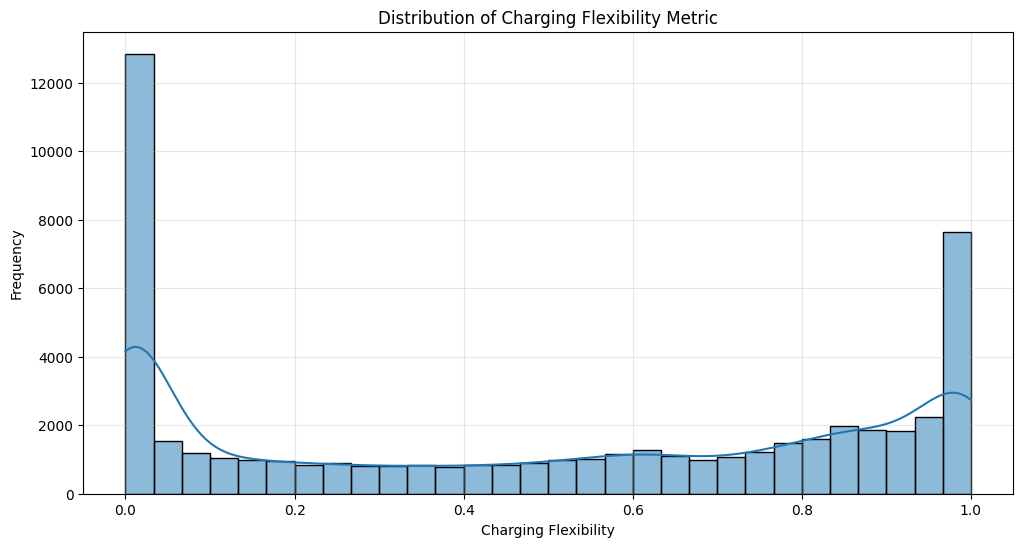

<Figure size 640x480 with 0 Axes>

In [49]:
# Visualize the charging flexibility metric
plt.figure(figsize=(12, 6))
sns.histplot(selected_sessions['charging_flexibility'], bins=30, kde=True)
plt.title('Distribution of Charging Flexibility Metric')
plt.xlabel('Charging Flexibility')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()
plt.tight_layout()



In [56]:
# return list of plugin event IDs with the station name containing 'Alco Station'
alco_station_event_ids = selected_sessions.loc[selected_sessions['Station Name'].str.contains('ALCO STATIONS', na=False), 
                                               'Plug In Event Id'].unique().tolist()
print("\n" + "="*60)
print("ALCO STATION EVENT IDS")
print("="*60)
print(alco_station_event_ids)

# Select sessions from the list of event IDs
selected_alco_sessions = selected_sessions[selected_sessions['Plug In Event Id'].isin(alco_station_event_ids)].copy()
# Display the first few rows of the selected Alco sessions
print("\n" + "="*60)
print("SELECTED ALCO SESSIONS")
print("="*60)
print(selected_alco_sessions.head())


ALCO STATION EVENT IDS
[183583741, 183563931, 183562971, 183550141, 183541191, 183539261, 183515441, 183494521, 183468851, 183465021, 183423981, 183418591, 183418001, 183384831, 183378301, 183366421, 183366091, 183361661, 183350501, 183342531, 183288221, 183213731, 183183001, 183140251, 183133091, 183110111, 183104191, 183103081, 183088871, 183064461, 183061451, 183049771, 183049261, 183041381, 183034661, 183022521, 183017471, 182974481, 182967721, 182928291, 182894791, 182893911, 182890471, 182883711, 182811741, 182805001, 182797261, 182795931, 182777421, 182751561, 182702191, 182682851, 182674101, 182671531, 182669661, 182627101, 182504771, 182464761, 182459611, 182449931, 182437241, 182427741, 182415851, 182413621, 182389291, 182349251, 182298551, 182283881, 182259451, 182254441, 182228471, 182217921, 182229871, 182170411, 182156361, 182133411, 182117191, 182109891, 182105951, 182100211, 182064471, 182052261, 182045961, 182045331, 182038241, 182016621, 182003861, 182002851, 1819922

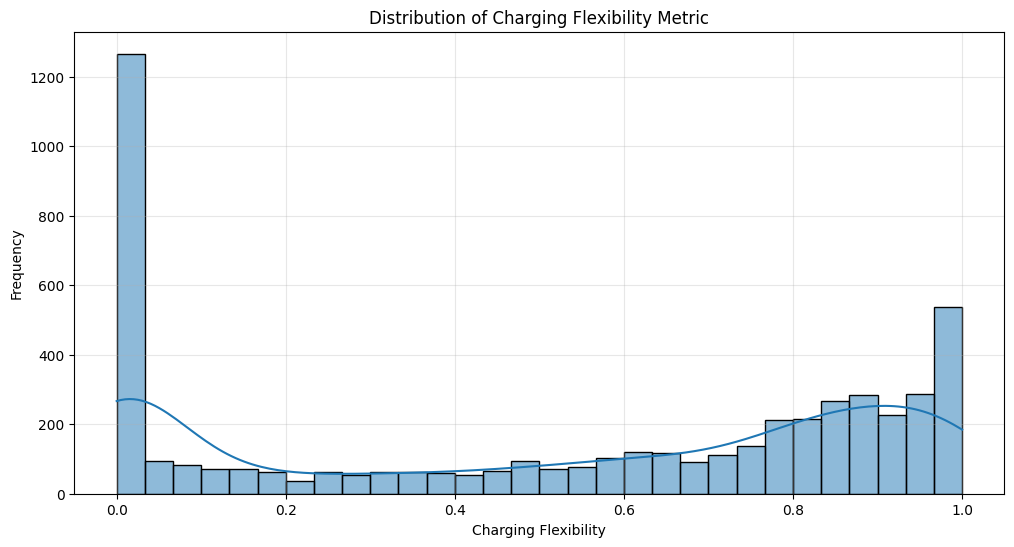

<Figure size 640x480 with 0 Axes>

In [57]:
# Visualize the charging flexibility metric
plt.figure(figsize=(12, 6))
sns.histplot(selected_alco_sessions['charging_flexibility'], bins=30, kde=True)
plt.title('Distribution of Charging Flexibility Metric')
plt.xlabel('Charging Flexibility')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()
plt.tight_layout()



## 6. Smart charging management (SCM) of charging session on an example day in one parking lot

In [87]:
# Display the start and end times of the selected Alco sessions
print("\n" + "="*60)
print("START AND END TIMES OF SELECTED ALCO SESSIONS")
print("="*60)
print(f"Start Time: {selected_alco_sessions['Start Time'].min()}")
print(f"End Time: {selected_alco_sessions['End Time'].max()}")

# Select sessions on a specific day (e.g., 2017-08-01)
selected_date = '2017-08-01'
selected_date_sessions = selected_alco_sessions[(selected_alco_sessions['Start Time'].dt.date == pd.to_datetime(selected_date).date())].copy()
# Display the first few rows of the selected date sessions
print("\n" + "="*60)
print("SELECTED DATE SESSIONS")
print("="*60)
print(selected_date_sessions.head())


START AND END TIMES OF SELECTED ALCO SESSIONS
Start Time: 2017-07-26 12:41:59
End Time: 2018-02-09 19:16:00

SELECTED DATE SESSIONS
        EVSE ID User Id  Plug In Event Id  Port  \
540015   174385   6279V          77344924     2   
540681    33903  146547          77340858     2   
540740    34463   6279V          77339080     2   
540795   174377  751363          77336462     1   
540871   122387   6337V          77335566     2   

                           Station Name User Id Port Type  Energy (kWh)  \
540015  ALCO STATIONS / 2ND FLR 4000 02   6279V   Level 2      7.230203   
540681   ALCO STATIONS / ALCOBASE - 004  146547   Level 2     12.326301   
540740   ALCO STATIONS / ALCOBASE - 003   6279V   Level 2      8.411539   
540795  ALCO STATIONS / 2ND FLR 4000 03  751363   Level 2      0.885824   
540871   ALCO STATIONS / ALCOBASE4000-3   6337V   Level 2      9.525474   

       Total Duration (hh:mm:ss) Charging Time (hh:mm:ss)   Plug Connect Time  \
540015                  05:2


SELECTED DATE INTERVALS
        EVSE ID User Id  Plug In Event Id    Power Start Time  \
540016   174385   6279V          77344924 2017-08-01 19:25:34   
540017   174385   6279V          77344924 2017-08-01 19:30:00   
540018   174385   6279V          77344924 2017-08-01 19:45:00   
540019   174385   6279V          77344924 2017-08-01 20:00:00   
540020   174385   6279V          77344924 2017-08-01 20:15:00   

            Power End Time  Peak Power (AC kW)  Rolling Avg. Power (AC kW)  \
540016 2017-08-01 19:29:59               3.743                       3.347   
540017 2017-08-01 19:44:59               3.739                       3.737   
540018 2017-08-01 19:59:59               3.733                       3.726   
540019 2017-08-01 20:14:59               3.734                       3.735   
540020 2017-08-01 20:29:59               3.734                       3.727   

        Energy Consumed (AC kWh)  Port  
540016                  0.247329     2  
540017                  0.934357 

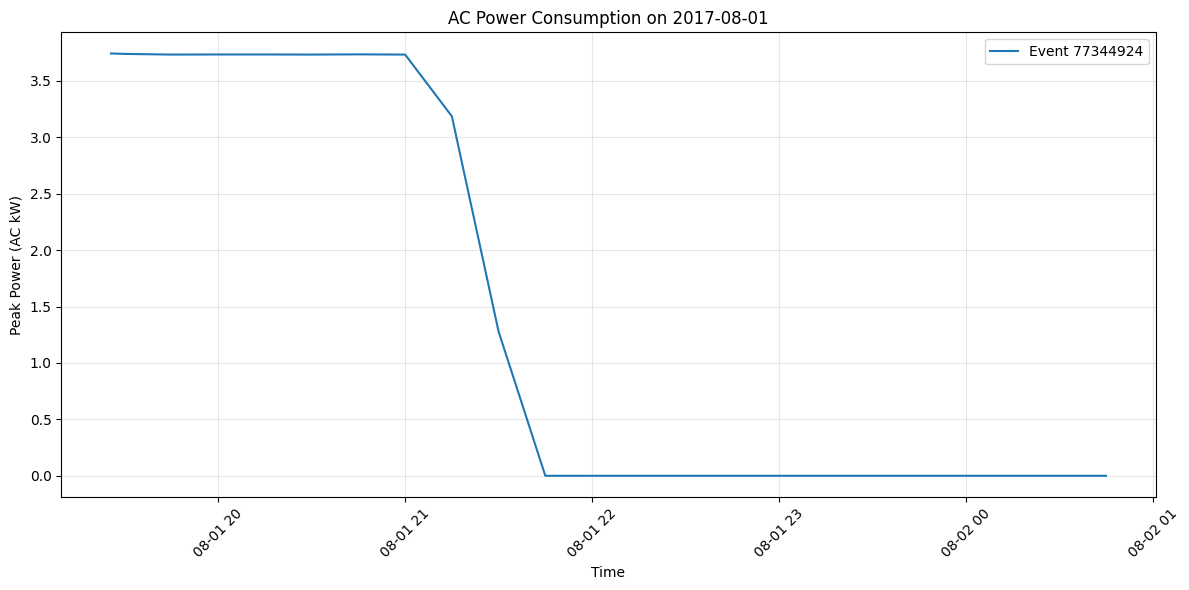

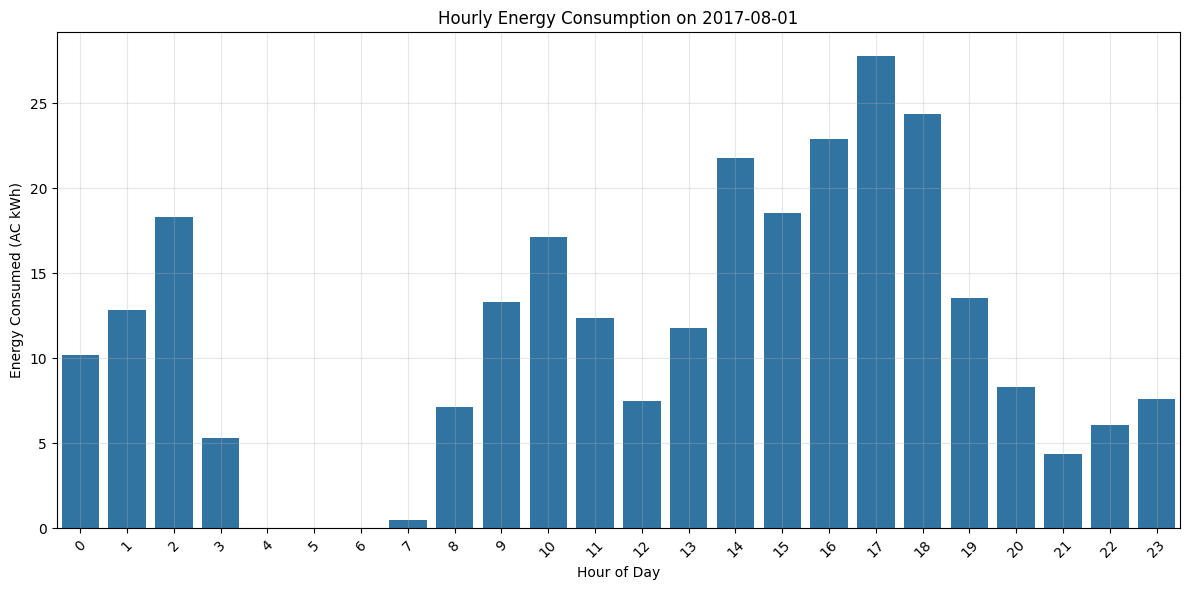

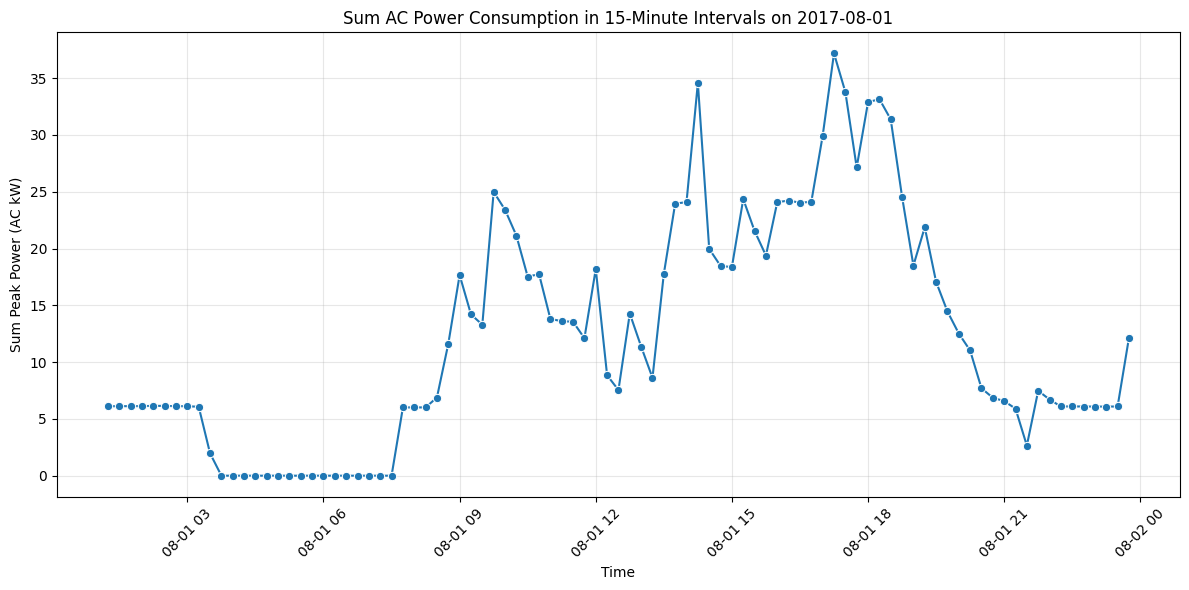

In [100]:
# Select the intervals for the selected date sessions
selected_date_intervals = time_intervals[time_intervals['Plug In Event Id'].isin(selected_date_sessions['Plug In Event Id'])].copy()
# Display the first few rows of the selected date intervals
print("\n" + "="*60)
print("SELECTED DATE INTERVALS")
print("="*60)
print(selected_date_intervals.head())

# Make a plot of one session's AC power consumption over time
if not selected_date_intervals.empty:
    plt.figure(figsize=(12, 6))
    for event_id in [77344924]:
        session_data = selected_date_intervals[selected_date_intervals['Plug In Event Id'] == event_id]
        plt.plot(session_data['Power Start Time'], session_data['Peak Power (AC kW)'], label=f'Event {event_id}')
    
    plt.title(f'AC Power Consumption on {selected_date}')
    plt.xlabel('Time')
    plt.ylabel('Peak Power (AC kW)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Aggregate the energy consumed by hour for the selected date intervals and plot it
if 'Energy Consumed (AC kWh)' in selected_date_intervals.columns:
    selected_date_intervals['Hour'] = selected_date_intervals['Power Start Time'].dt.hour
    hourly_energy = selected_date_intervals.groupby('Hour')['Energy Consumed (AC kWh)'].sum().reset_index()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Hour', y='Energy Consumed (AC kWh)', data=hourly_energy, color='tab:blue')
    plt.title(f'Hourly Energy Consumption on {selected_date}')
    plt.xlabel('Hour of Day')
    plt.ylabel('Energy Consumed (AC kWh)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Make a aggregated AC power consumption plot for the selected date intervals in 15-minute intervals
if 'Power Start Time' in selected_date_intervals.columns:
    selected_date_intervals['15-Minute Interval'] = selected_date_intervals['Power Start Time'].dt.floor('15T')
    aggregated_power = selected_date_intervals.groupby('15-Minute Interval')['Peak Power (AC kW)'].sum().reset_index()

    # Limit the plot to the selected date
    aggregated_power = aggregated_power[aggregated_power['15-Minute Interval'].dt.date == pd.to_datetime(selected_date).date()]
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='15-Minute Interval', y='Peak Power (AC kW)', data=aggregated_power, marker='o')
    plt.title(f'Sum AC Power Consumption in 15-Minute Intervals on {selected_date}')
    plt.xlabel('Time')
    plt.ylabel('Sum Peak Power (AC kW)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [93]:
# Convert the start and end times to 15-minute intervals for the selected date sessions
if 'Start Time' in selected_date_sessions.columns:
    selected_date_sessions['15-Minute Interval Start'] = selected_date_sessions['Start Time'].dt.floor('15T')
    selected_date_sessions['15-Minute Interval End'] = selected_date_sessions['End Time'].dt.ceil('15T')

    # Display the first few rows of the updated intervals
    print("\n" + "="*60)
    print("SELECTED DATE SESSIONS WITH 15-MINUTE INTERVALS")
    print("="*60)
    print(selected_date_sessions.head())


SELECTED DATE SESSIONS WITH 15-MINUTE INTERVALS
        EVSE ID User Id  Plug In Event Id  Port  \
540015   174385   6279V          77344924     2   
540681    33903  146547          77340858     2   
540740    34463   6279V          77339080     2   
540795   174377  751363          77336462     1   
540871   122387   6337V          77335566     2   

                           Station Name User Id Port Type  Energy (kWh)  \
540015  ALCO STATIONS / 2ND FLR 4000 02   6279V   Level 2      7.230203   
540681   ALCO STATIONS / ALCOBASE - 004  146547   Level 2     12.326301   
540740   ALCO STATIONS / ALCOBASE - 003   6279V   Level 2      8.411539   
540795  ALCO STATIONS / 2ND FLR 4000 03  751363   Level 2      0.885824   
540871   ALCO STATIONS / ALCOBASE4000-3   6337V   Level 2      9.525474   

       Total Duration (hh:mm:ss) Charging Time (hh:mm:ss)   Plug Connect Time  \
540015                  05:28:05                 02:06:09 2017-08-01 19:25:34   
540681                  13:55:4

In [98]:
# Extract plugin event IDs and their corresponding start and end times and Energy (kWh)
extracted_data = selected_date_sessions[['Plug In Event Id', '15-Minute Interval Start', '15-Minute Interval End', 'Energy (kWh)']].copy()
# Rename columns for clarity
extracted_data.rename(columns={
    '15-Minute Interval Start': 'start_time',
    '15-Minute Interval End': 'end_time',
    'Energy (kWh)': 'energy_charged_kWh'
}, inplace=True)
# Export the extracted data to a list of dictionaries as JSON
print("\n" + "="*60)
print("EXTRACTED DATA FOR SMART CHARGING MANAGEMENT")
print("="*60)
print(extracted_data.head())

# Convert the extracted data to a list of dictionaries
extracted_data_list = extracted_data.to_dict(orient='records')
# Export the extracted data to a JSON file
import json
with open(f'data/chapter5/extracted_data_{selected_date}.json', 'w') as json_file:
    json.dump(extracted_data_list, json_file, default=str)





EXTRACTED DATA FOR SMART CHARGING MANAGEMENT
        Plug In Event Id          start_time            end_time  \
540015          77344924 2017-08-01 19:15:00 2017-08-02 01:00:00   
540681          77340858 2017-08-01 18:15:00 2017-08-02 08:30:00   
540740          77339080 2017-08-01 18:00:00 2017-08-02 07:15:00   
540795          77336462 2017-08-01 17:30:00 2017-08-01 17:45:00   
540871          77335566 2017-08-01 17:15:00 2017-08-02 09:15:00   

        energy_charged_kWh  
540015            7.230203  
540681           12.326301  
540740            8.411539  
540795            0.885824  
540871            9.525474  


In [91]:
# Save the selected date sessions and intervals to CSV files for charging control
selected_date_sessions.to_csv(f'data/chapter5/selected_date_sessions_{selected_date}.csv', index=False)
selected_date_intervals.to_csv(f'data/chapter5/selected_date_intervals_{selected_date}.csv', index=False)